In [1]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPModel, CLIPProcessor, AdamW, get_scheduler
from tqdm import tqdm

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
caption_dir = "/root/20242R0136COSE47402/FinalProject/src/class_captions.json"

with open (caption_dir, 'r') as file:
    class_captions = json.load(file)

In [3]:
# train dataset
data_dir = "/root/20242R0136COSE47402/FinalProject/data/train"
class_candidate = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
text_inputs = []
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        folder = folder.replace('_', ' ')
        text_inputs.append(f"{folder}. {class_captions[folder]}")

In [4]:
image_paths = []
image_labels = []

for class_name in class_candidate:
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        if img_name[0] == '.':
            continue
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        class_name = class_name.replace('_', ' ')
        image_labels.append(class_name)

print(f"test dataset size : {len(image_paths)}")

test dataset size : 75750


In [5]:
def collate_fn(batch):
    inputs, labels = zip(*batch)

    input_ids = [inp['input_ids'] for inp in inputs]
    attention_masks = [inp['attention_mask'] for inp in inputs]
    pixel_values = [inp['pixel_values'] for inp in inputs]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    pixel_values = torch.stack(pixel_values)

    batch_inputs = {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'pixel_values': pixel_values
    }

    return batch_inputs, labels


In [6]:
def clip_loss(logits_per_image):
    targets = torch.arange(len(logits_per_image), device=logits_per_image.device)

    return (F.cross_entropy(logits_per_image, targets) + F.cross_entropy(logits_per_image.T, targets)) / 2


In [7]:
class Food101DataSet(Dataset):
    def __init__(self, image_paths, image_labels, processor):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.processor = processor
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.image_labels[idx]
        inputs = self.processor(text=label, images=image, return_tensors='pt')
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

train_dataset = Food101DataSet(image_paths, image_labels, processor)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [8]:
torch.cuda.empty_cache()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [10]:
for param in model.parameters():
    param.requires_grad = True

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
epochs = 12
num_warmup_steps = int(0.1 * len(train_dataloader)) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=len(train_dataloader) * epochs)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
model.train()
losses = []

for epoch in range(epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} / {epochs}")
    for batch in progress_bar:
        batch_inputs, labels = batch 
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        outputs = model(**batch_inputs)

        logits_per_image = outputs.logits_per_image
        loss = clip_loss(logits_per_image)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=loss.item())
    print(f"epoch {epoch + 1} finished.")

print("Train completed.")

Epoch 1 / 12: 100%|██████████| 9469/9469 [38:29<00:00,  4.10it/s, loss=0.521]  


epoch 1 finished.


Epoch 2 / 12: 100%|██████████| 9469/9469 [38:47<00:00,  4.07it/s, loss=0.823] 


epoch 2 finished.


Epoch 3 / 12: 100%|██████████| 9469/9469 [38:33<00:00,  4.09it/s, loss=0.317] 


epoch 3 finished.


Epoch 4 / 12: 100%|██████████| 9469/9469 [38:43<00:00,  4.07it/s, loss=0.72]  


epoch 4 finished.


Epoch 5 / 12: 100%|██████████| 9469/9469 [38:37<00:00,  4.09it/s, loss=0.15]   


epoch 5 finished.


Epoch 6 / 12: 100%|██████████| 9469/9469 [38:45<00:00,  4.07it/s, loss=0.0905] 


epoch 6 finished.


Epoch 7 / 12: 100%|██████████| 9469/9469 [38:32<00:00,  4.09it/s, loss=0.00397] 


epoch 7 finished.


Epoch 8 / 12: 100%|██████████| 9469/9469 [38:07<00:00,  4.14it/s, loss=0.639]   


epoch 8 finished.


Epoch 9 / 12: 100%|██████████| 9469/9469 [38:01<00:00,  4.15it/s, loss=0.462]   


epoch 9 finished.


Epoch 10 / 12: 100%|██████████| 9469/9469 [38:13<00:00,  4.13it/s, loss=0.000545]


epoch 10 finished.


Epoch 11 / 12: 100%|██████████| 9469/9469 [38:12<00:00,  4.13it/s, loss=0.0013]  


epoch 11 finished.


Epoch 12 / 12: 100%|██████████| 9469/9469 [38:17<00:00,  4.12it/s, loss=0.000243]

epoch 12 finished.
Train completed.


In [12]:
loss_store_path = "/root/20242R0136COSE47402/FinalProject/src/sept_clip_loss.txt"
with open (loss_store_path, 'w') as file:
    for loss in losses:
        file.write(f"{loss}\n")

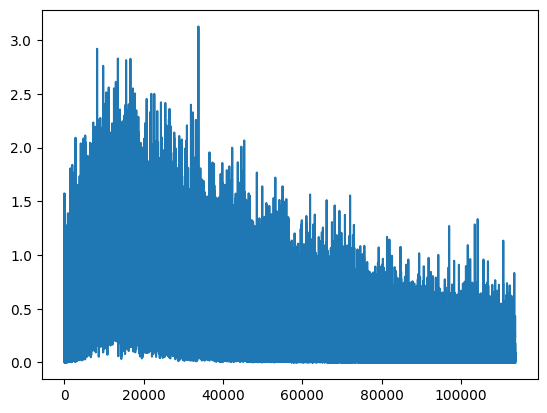

In [13]:
plt.plot(losses)
plt.show()

In [14]:
# test dataset
data_dir = "/root/20242R0136COSE47402/FinalProject/data/test"
class_candidate = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
text_inputs = []
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        folder = folder.replace('_', ' ')
        text_inputs.append(f"{folder}. {class_captions[folder]}")

In [15]:
image_paths = []
image_labels = []

for class_name in class_candidate:
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        if img_name[0] == '.':
            continue
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        class_name = class_name.replace('_', ' ')
        image_labels.append(class_name)

print(f"test dataset size : {len(image_paths)}")

test dataset size : 25250


In [16]:
ans = 0
model.eval()

for idx, img_path in enumerate(image_paths):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(text=text_inputs, images=image, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    result = text_inputs[torch.argmax(probs).item()]
    if result.split('.')[0] == image_labels[idx]:
        ans += 1
    if idx % 2000 == 0:
        print(f"# {idx} finished.")

precision = ans / len(image_paths)
precision


# 0 finished.


# 2000 finished.
# 4000 finished.
# 6000 finished.
# 8000 finished.
# 10000 finished.
# 12000 finished.
# 14000 finished.
# 16000 finished.
# 18000 finished.
# 20000 finished.
# 22000 finished.
# 24000 finished.


0.36146534653465345